<a href="https://colab.research.google.com/github/zenosance/machine-learning/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1

RNN untuk Analisis Sentimen

## Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:


In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
   plt.plot(history.history[metric])
   plt.plot(history.history['val_'+metric], '')
   plt.xlabel("Epochs")
   plt.ylabel(metric)
   plt.legend([metric, 'val_'+metric])

## Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.
Download dataset menggunakan [TFDS](https://www.tensorflow.org/datasets). [Lihat loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) jika ingin me load data secara manual

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Since Douglas MacArthur affected more human lives\xc2\x97for the better\xc2\x97than any other American not elected President, he deserved a better film biography. Not that Universal\'s "MacArthur" is bad. It\'s just not all it should have been.<br /><br />Oddly enough, the potential was there. From the very early "Star Trek" episode "The Corbomite Maneuver" (1966) to the recent HBO films "Something the Lord Made" (2OO4) and "Warm Springs" (2OO5), director Joseph Sargent has emerged as one of the most expressively human directors in film, a man capable of subtly shaping the emotional shadings of his actors\' performances, and carrying the audience exactly where he wants them to go. The producer, Frank McCarthy, also gave us "Patton" (197O), the legendary Jerry Goldsmith scored both films, and Universal widely touted the fact that the film was "four years in preparation and production." Yet for all of this, "MacArthur" is perfectly adequate\xc2\x97and not much more than that.<

## Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [8]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [9]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[231,   1,   1, ...,   0,   0,   0],
       [ 10, 175, 130, ...,   0,   0,   0],
       [414,  11,   7, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Since Douglas MacArthur affected more human lives\xc2\x97for the better\xc2\x97than any other American not elected President, he deserved a better film biography. Not that Universal\'s "MacArthur" is bad. It\'s just not all it should have been.<br /><br />Oddly enough, the potential was there. From the very early "Star Trek" episode "The Corbomite Maneuver" (1966) to the recent HBO films "Something the Lord Made" (2OO4) and "Warm Springs" (2OO5), director Joseph Sargent has emerged as one of the most expressively human directors in film, a man capable of subtly shaping the emotional shadings of his actors\' performances, and carrying the audience exactly where he wants them to go. The producer, Frank McCarthy, also gave us "Patton" (197O), the legendary Jerry Goldsmith scored both films, and Universal widely touted the fact that the film was "four years in preparation and production." Yet for all of this, "MacArthur" is perfectly adequate\xc2\x97and not much more than that

## Buat Model

diagram model dapat dilihat pada gambar diatas
1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  -Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  -Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide
Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00116725]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[0.00116725]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 104ms/step - loss: 0.6385 - accuracy: 0.5744 - val_loss: 0.4783 - val_accuracy: 0.7922
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3894 - accuracy: 0.8193 - val_loss: 0.3746 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3344 - accuracy: 0.8528 - val_loss: 0.3362 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3187 - accuracy: 0.8594 - val_loss: 0.3284 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3119 - accuracy: 0.8655 - val_loss: 0.3267 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3063 - accuracy: 0.8684 - val_loss: 0.3302 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3031 - accuracy: 0.8686 - val_loss: 0.3249 - val_accuracy

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3344 - accuracy: 0.8469
Test Loss: 0.33444899320602417
Test Accuracy: 0.8468800187110901


(0.0, 0.6555146098136901)

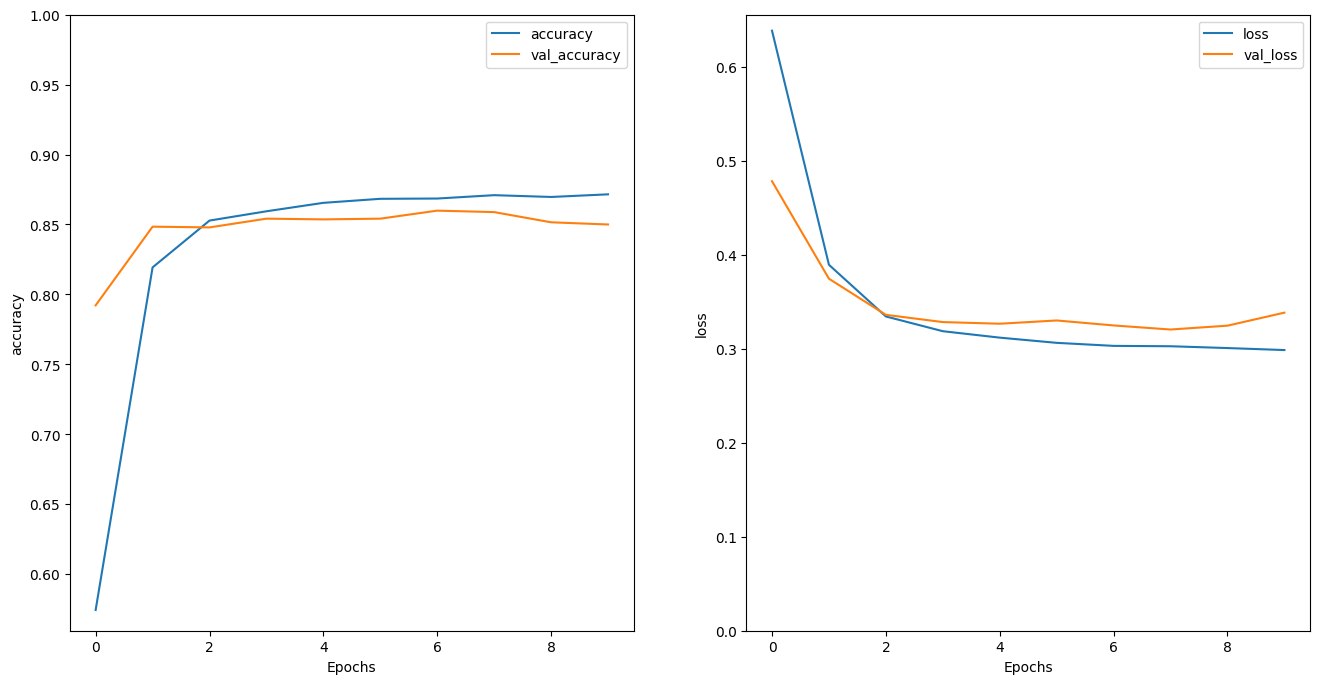

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).
Berikut adalah alur informasi dengan return_sequences=True:

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [20]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 148ms/step - loss: 0.6199 - accuracy: 0.5962 - val_loss: 0.4196 - val_accuracy: 0.8224
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3869 - accuracy: 0.8330 - val_loss: 0.3535 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3370 - accuracy: 0.8580 - val_loss: 0.3410 - val_accuracy: 0.8635
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3195 - accuracy: 0.8657 - val_loss: 0.3217 - val_accuracy: 0.8661
Epoch 5/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3099 - accuracy: 0.8688 - val_loss: 0.3271 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3066 - accuracy: 0.8715 - val_loss: 0.3223 - val_accuracy: 0.8630
Epoch 7/10
391/391 [==============================] - 46s 116ms/step - loss: 0.2999 - accuracy: 0.8730 - val_loss: 0.3282 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3161 - accuracy: 0.8607
Test Loss: 0.31607258319854736
Test Accuracy: 0.8606799840927124


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0763369]]


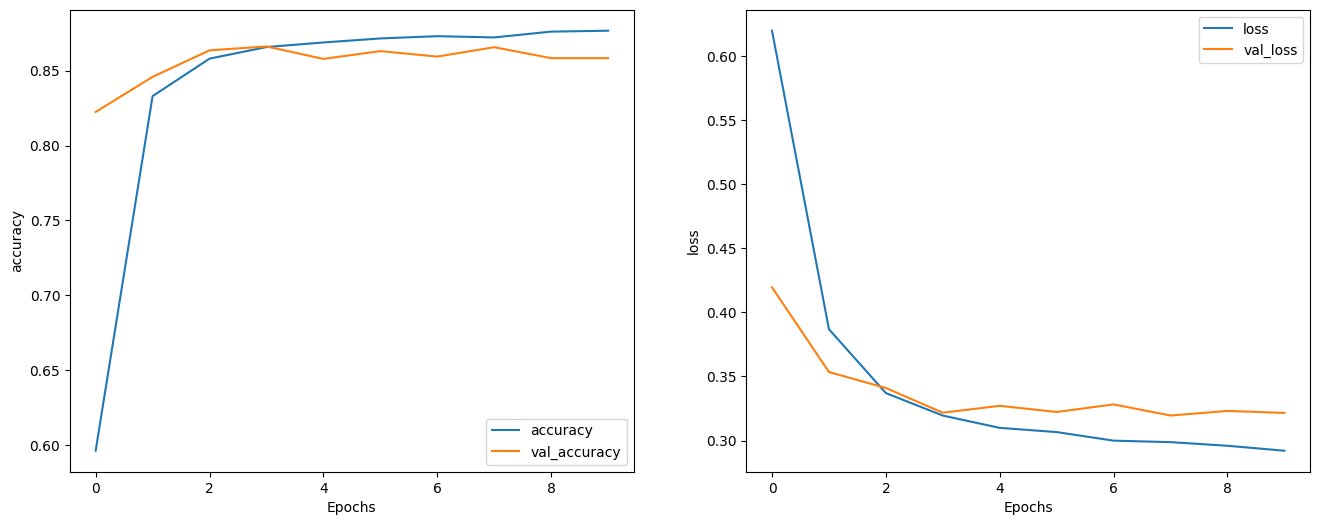

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')